In [2]:
from IPython.display import clear_output
!pip install imutils
!pip install colorama
clear_output()

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf
from PIL import Image
import tqdm

from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import normalize, to_categorical

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from tensorflow.keras import layers, Sequential
from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [4]:
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import scipy

import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.utils import *
# import pydot

from sklearn.metrics import *
from sklearn.model_selection import *
import tensorflow.keras.backend as K

from tqdm import tqdm, tqdm_notebook
from colorama import Fore
import json
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from skimage.io import *
%config Completer.use_jedi = False
import time
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import lightgbm as lgb
import xgboost as xgb
import numpy as np 
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping


from keras.models import Model
from keras.layers import Flatten,Dense, Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D , GlobalMaxPooling2D, Dropout

init_notebook_mode(connected=True)
RANDOM_SEED = 50  #123

print("All modules have been imported")

All modules have been imported


In [5]:
!apt-get install tree
clear_output()
# create new folders
!mkdir TRAIN TEST VAL TRAIN/YES TRAIN/NO TEST/YES TEST/NO VAL/YES VAL/NO
!tree -d

.
├── TEST
│   ├── NO
│   └── YES
├── TEST_CROP
│   └── filtered
│       ├── NO
│       └── YES
├── TRAIN
│   ├── NO
│   └── YES
├── TRAIN_CROP
│   └── filtered
│       ├── NO
│       └── YES
├── VAL
│   ├── NO
│   └── YES
└── VAL_CROP
    └── filtered
        ├── NO
        └── YES

21 directories


In [6]:
IMG_PATH = "/kaggle/input/brain-tumor-detection"

# split the data by train/val/test
# ignored = {"pred","Br35H-Mask-RCNN"}
accepted = {"no", "yes"}
# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    if CLASS in accepted:
        if not CLASS.startswith('.'):
            IMG_NUM = len(os.listdir(IMG_PATH +"/"+ CLASS))
            for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH +"/"+ CLASS)):
                img = IMG_PATH+ '/' +  CLASS + '/' + FILE_NAME
                if n < 200:
                    shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
                elif n < 0.80*IMG_NUM:
                    shutil.copy(img, 'TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)
                else:
                    shutil.copy(img, 'VAL/'+ CLASS.upper() + '/' + FILE_NAME)

In [7]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


In [8]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 2/2 [00:03<00:00,  1.86s/it]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



2000 images loaded from TRAIN/ directory.


100%|██████████| 2/2 [00:00<00:00,  2.88it/s]


400 images loaded from TEST/ directory.


100%|██████████| 2/2 [00:01<00:00,  1.95it/s]

600 images loaded from VAL/ directory.


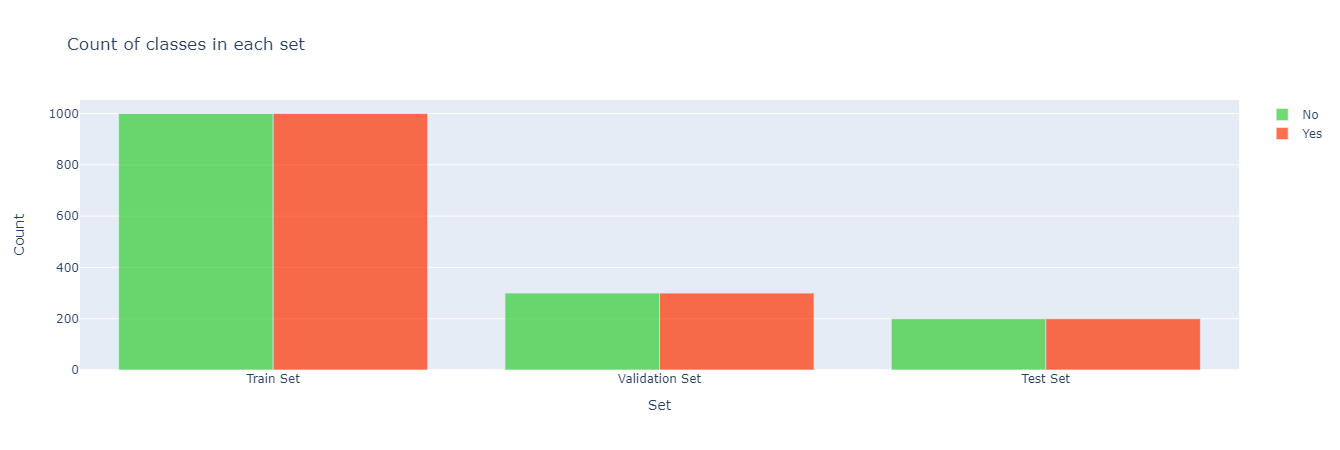

In [9]:
y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)

In [10]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

In [11]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

In [12]:
import imutils
img = cv2.imread('/kaggle/working/TRAIN/YES/y147.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

In [13]:
# os.listdir("/kaggle/working/TRAIN/YES")

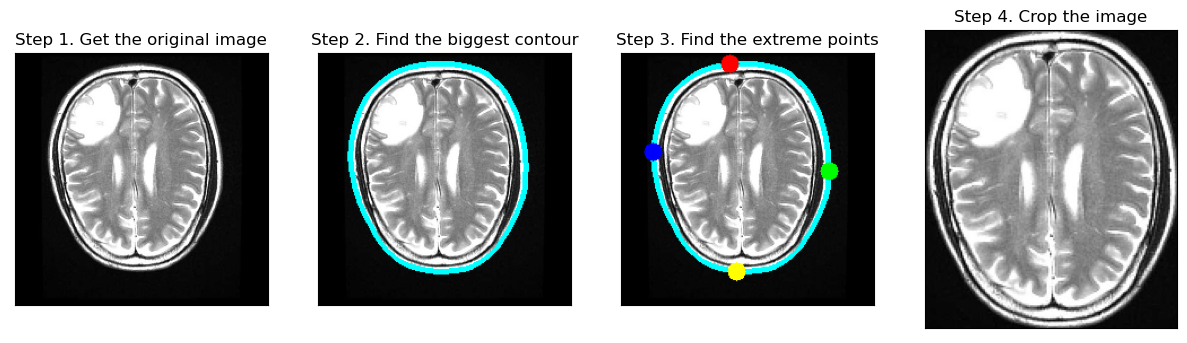

In [14]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [15]:
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



In [16]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [17]:
# saving new images to the folder
!mkdir TRAIN_CROP TEST_CROP VAL_CROP TRAIN_CROP/YES TRAIN_CROP/NO TEST_CROP/YES TEST_CROP/NO VAL_CROP/YES VAL_CROP/NO

save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

mkdir: cannot create directory ‘TRAIN_CROP’: File exists
mkdir: cannot create directory ‘TEST_CROP’: File exists
mkdir: cannot create directory ‘VAL_CROP’: File exists


In [18]:
!zip -r /kaggle/working/output.zip /kaggle/working/

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/TRAIN/ (stored 0%)
  adding: kaggle/working/TRAIN/NO/ (stored 0%)
  adding: kaggle/working/TRAIN/NO/no428.jpg (deflated 3%)
  adding: kaggle/working/TRAIN/NO/no162.jpg (deflated 4%)
  adding: kaggle/working/TRAIN/NO/no297.jpg (deflated 6%)
  adding: kaggle/working/TRAIN/NO/no1393.jpg (deflated 2%)
  adding: kaggle/working/TRAIN/NO/no831.jpg (deflated 2%)
  adding: kaggle/working/TRAIN/NO/no807.jpg (deflated 2%)
  adding: kaggle/working/TRAIN/NO/no342.jpg (deflated 1%)
  adding: kaggle/working/TRAIN/NO/no1460.jpg (deflated 3%)
  adding: kaggle/working/TRAIN/NO/no75.jpg (deflated 2%)
  adding: kaggle/working/TRAIN/NO/no1444.jpg (deflated 3%)
  adding: kaggle/working/TRAIN/NO/no1287.jpg (deflated 2%)
  adding: kaggle/working/TRAIN/NO/no559.jpg (deflated 2%)
  adding: kaggle/working/TRAIN/NO/no417.jpg (deflated 1%)
  adding: kaggle/working/TRAIN/NO/no416.jpg (deflated 1%)
  adding: kaggle/working/TRAIN/NO/no1392.jpg (deflated 3

In [19]:
train_crop ='/kaggle/working/TRAIN_CROP'
test_crop ='/kaggle/working/TEST_CROP'
val_crop ='/kaggle/working/VAL_CROP'

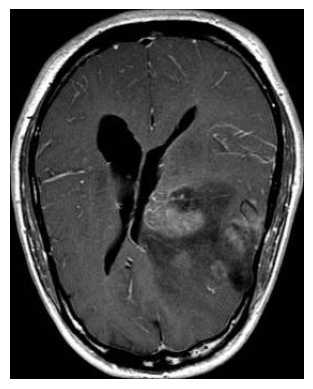

In [20]:
import matplotlib.pyplot as plt

# Load the image
image_path = '/kaggle/working/TEST_CROP/YES/398.jpg'
image = cv2.imread(image_path)

# Check if the image was successfully loaded
if image is not None:
    # Convert BGR image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()
else:
    print('Failed to load the image.')

In [21]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import os
from PIL import ImageOps
from tqdm import tqdm

# Custom preprocessing functions
def mean_filter(img):
    img = tf.expand_dims(img, axis=0)
    img_filtered = tf.nn.avg_pool2d(img, ksize=3, strides=1, padding='SAME')
    img_filtered = tf.squeeze(img_filtered, axis=0)
    return img_filtered

def median_filter(img):
    return tfa.image.median_filter2d(img, filter_shape=(3, 3), padding='REFLECT')

def histogram_equalization(img):
    img_pil = array_to_img(img)
    img_eq = ImageOps.equalize(img_pil)
    return img_to_array(img_eq)

# Define the folders
folders = ['TRAIN_CROP', 'TEST_CROP', 'VAL_CROP']
labels = ['YES', 'NO']

# Create the filtered image directories if they don't exist
for folder in folders:
    filtered_folder = os.path.join(folder, 'filtered')
    os.makedirs(filtered_folder, exist_ok=True)
    for label in labels:
        label_folder = os.path.join(filtered_folder, label)
        os.makedirs(label_folder, exist_ok=True)

# Loop through each folder and process the images
for folder in folders:
    for label in labels:
        folder_path = os.path.join(folder, label)
        images = os.listdir(folder_path)

        for image_name in tqdm(images, desc=f'Processing {folder}/{label}'):
            # Load the image
            image_path = os.path.join(folder_path, image_name)
            img = load_img(image_path, color_mode='grayscale')
            img_array = img_to_array(img)

            # Apply histogram equalization
            img_eq = histogram_equalization(img_array)

            # Apply mean filter
           # img_mean = mean_filter(img_eq)

            # Apply median filter
            img_median = median_filter(img_eq)

            # Save the filtered image
            filtered_folder = os.path.join(folder, 'filtered', label)
            filtered_path = os.path.join(filtered_folder, image_name)
            filtered_img = array_to_img(img_median, scale=False)
            filtered_img.save(filtered_path)

print("Filters applied to all images!")




Processing VAL_CROP/NO: 100%|██████████| 300/300 [00:28<00:00, 10.63it/s]

Filters applied to all images!


In [22]:
TRAIN_FILTERED = '/kaggle/working/TRAIN_CROP/filtered'
TEST_FILTERED = '/kaggle/working/TEST_CROP/filtered'
VAL_FILTERED = '/kaggle/working/VAL_CROP/filtered'

In [23]:
/kaggle/working/VAL_CROP/filtered/YES/augmented_385.jpg_2.jpg

NameError: name 'kaggle' is not defined

In [24]:
batch_size = 32
image_size = (224, 224)

# Use the ImageDataGenerator to preprocess and load the train dataset
train_datagen = ImageDataGenerator(rescale=1.0/255.0)  # Rescale pixel values to [0, 1]
train_generator = train_datagen.flow_from_directory(
    TRAIN_FILTERED,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    
)

# Use the ImageDataGenerator to preprocess and load the validation dataset
validation_datagen = ImageDataGenerator(rescale=1.0/255.0)  # Rescale pixel values to [0, 1]
validation_generator = validation_datagen.flow_from_directory(
    VAL_FILTERED,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

# Use the ImageDataGenerator to preprocess and load the test dataset
test_datagen = ImageDataGenerator(rescale=1.0/255.0)  # Rescale pixel values to [0, 1]
test_generator = test_datagen.flow_from_directory(
    TEST_FILTERED,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 2000 images belonging to 2 classes.
Found 600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [25]:
def cnn_model():
    cnn_sequential=Sequential([
        layers.Input(shape=(224,224,3), name='input_image'),

        layers.Conv2D(32, kernel_size=3, activation='relu',kernel_initializer='he_uniform'),
         layers.Conv2D(32, kernel_size=3, activation='relu',kernel_initializer='he_uniform'),
        layers.MaxPool2D(pool_size=2),

        layers.Conv2D(64, kernel_size=3, activation='relu',kernel_initializer='he_uniform'),
        layers.MaxPool2D(pool_size=2),

        layers.Conv2D(64, kernel_size=3, activation='relu',kernel_initializer='he_uniform'),
        layers.MaxPool2D(pool_size=2),

        layers.Conv2D(128, kernel_size=3, activation='relu',kernel_initializer='he_uniform'),
        layers.MaxPool2D(pool_size=2),

        layers.Flatten(),
        layers.Dense(64,activation='relu'),

        layers.Dropout(0.5),
        layers.Dense(1,activation='sigmoid')

    ], name='cnn_sequential_model')

    return cnn_sequential

In [26]:
model = cnn_model()

In [27]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True)


In [28]:
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

In [29]:

# Set the number of training steps per epoch
steps_per_epoch = train_generator.samples // train_generator.batch_size

# Set the number of validation steps
validation_steps = validation_generator.samples // validation_generator.batch_size



In [30]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=validation_steps
)

Epoch 1/30


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



62/62 [==============================] - 25s 137ms/step - loss: 0.7710 - accuracy: 0.6123 - val_loss: 0.5500 - val_accuracy: 0.7170
Epoch 2/30
62/62 [==============================] - 8s 131ms/step - loss: 0.4836 - accuracy: 0.7851 - val_loss: 0.4476 - val_accuracy: 0.8056
Epoch 3/30
62/62 [==============================] - 9s 140ms/step - loss: 0.3982 - accuracy: 0.8359 - val_loss: 0.2986 - val_accuracy: 0.8924
Epoch 4/30
62/62 [==============================] - 7s 115ms/step - loss: 0.3012 - accuracy: 0.8791 - val_loss: 0.2592 - val_accuracy: 0.8993
Epoch 5/30
62/62 [==============================] - 7s 118ms/step - loss: 0.2230 - accuracy: 0.9116 - val_loss: 0.2462 - val_accuracy: 0.9115
Epoch 6/30
62/62 [==============================] - 8s 136ms/step - loss: 0.1877 - accuracy: 0.9324 - val_loss: 0.1789 - val_accuracy: 0.9549
Epoch 7/30
62/62 [==============================] - 7s 116ms/step - loss: 0.1575 - accuracy: 0.9339 - val_loss: 0.1983 - val_accuracy: 0.9392
Epoch 8/30
62/62